# Introduction to cartopy

In [1]:
# initialization
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

## Prelude: the Earth is round, but the map is flat

Due to the fundamental fact that the Earth is round, it is impossible to represent all of areas, lengths, and angles faithfully on a flat sheet. Therefore, all maps are distorted in one way or another. However, different **projectioon** of the curved Earth surface onto flat 2-dimensional sheets may be more or less useful in a given situation.

Up to this point, we have been treating longitude and latitude as ordinary x- and y- axis. As a result, when we plot both longitude (as x-axis) and latitude (as y-axis), we have essentially been using the plate carrée map projection, which distorts areas and lengths as we move away from the equator.

In matplotlib, there is no easy way to switch to a different projection. However, the third-party **cartopy** module can be used to extend matplotlib, thus allowing us to specify data in the plate carrée coordinates but present them under a different projection. In addition, cartopy also comes bundled with information about geographical features, which can be conveniently included in plots.

## Map projections in cartopy

Instead of importing the entire cartopy package, we import two submodules from it:

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

(Note that _crs_ is short for coordinate reference system)

The `ccrs` submodule provide tools for map projection, while `cfeature` let us include geographical features in our plots.

A cartopy plot is not much different from a standard matplotlib plot, except that: (1) when Axes instances are created, we need to supply one of the crs implemented by cartopy in the `projection` argument; (2) when we add data via `.polormesh()`, `.contour()`, etc., we need to supply the source coordinate system as represented in cartopy using the `transform` argument.

To illustrate how cartopy works, we display the world's coastline using the `.coastlines()` method available to all cartopy-augmented Axes instances, for the usual plate carrée projection:

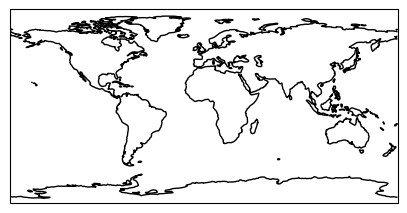

In [4]:
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(projection=ccrs.PlateCarree())

ax.coastlines()

plt.show(fig)

Again, note that the above code block is similar to how typical matplotlib plot is created thus far except for the `projection=ccrs.PlateCarree()` argument in `.add_subplot()`, and the `ax.coastlines()` line that generates the coastlines in the plot.

Next, we show the same coastlines in a few different map projections:

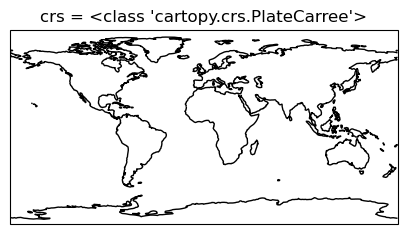

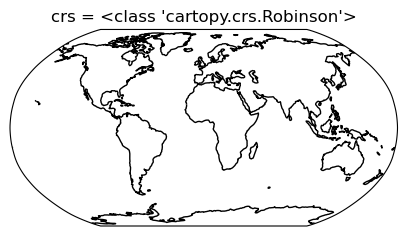

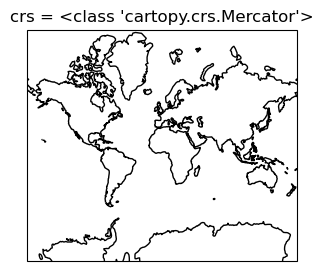

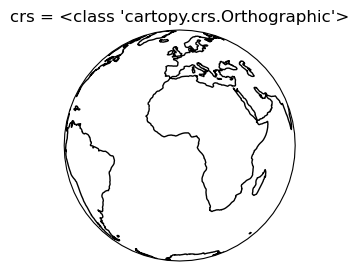

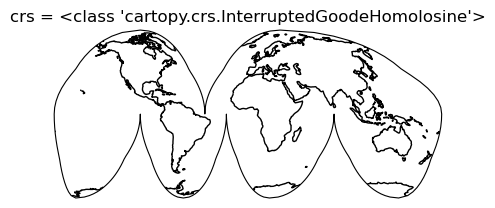

In [7]:
projections = [
    ccrs.PlateCarree(),
    ccrs.Robinson(),
    ccrs.Mercator(),
    ccrs.Orthographic(),
    ccrs.InterruptedGoodeHomolosine()
]

for proj in projections:
    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_subplot(projection=proj)
    ax.coastlines()
    ax.set_title("crs = " + str(type(proj)))
    plt.show(fig)

For a full list of supported map projection, see [https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html). In addition, a good resource for more information about various map projections is provided by ArcGIS and can be found [here](https://pro.arcgis.com/en/pro-app/latest/help/mapping/properties/list-of-supported-map-projections.htm) (unfortunately, the ArcGIS projection name does not always match that of cartopy)

If you are plotting global data, the Robinson projection may serve as a good default.

## Plotting global ocean data

Next we consider including actual data in our plot. For our examples we will be using the data from the [World Ocean Altas](https://www.ncei.noaa.gov/products/world-ocean-atlas) 2023. We will plot the ocean surface oxygen concentration. We first load the data (note: the WOA dataset has unusual encoding for time, to avoid problems we set `decode_times=False` in `xr.open_dataset()`):

In [6]:
woa23_O = xr.open_dataset("data/woa23_all_o00_5d.nc", decode_times=False)
display(woa23_O)

<xarray.Dataset> Size: 5MB
Dimensions:             (lat: 36, nbounds: 2, lon: 72, depth: 102, time: 1)
Coordinates:
  * lat                 (lat) float32 144B -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * lon                 (lon) float32 288B -177.5 -172.5 -167.5 ... 172.5 177.5
  * depth               (depth) float32 408B 0.0 5.0 10.0 ... 5.4e+03 5.5e+03
  * time                (time) float32 4B 3.894e+03
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 4B ...
    lat_bnds            (lat, nbounds) float32 288B ...
    lon_bnds            (lon, nbounds) float32 576B ...
    depth_bnds          (depth, nbounds) float32 816B ...
    climatology_bounds  (time, nbounds) float32 8B ...
    o_mn                (time, depth, lat, lon) float32 1MB ...
    o_dd                (time, depth, lat, lon) float64 2MB ...
    o_sd                (time, depth, lat, lon) float32 1MB ...
    o_se                (time, depth, lat, lon) float32 1MB ...
Attributes: (12/45)
    Conventions:                     CF-1.6
    title:                           World Ocean Atlas 2023 : moles_of_oxygen...
    summary:                         Climatological mean dissolved oxygen for...
    references:                      Garcia, H.E., Z. Wang, C. Bouchard, S.L....
    institution:                     NOAA National Centers for Environmental ...
    comment:                         Global Climatology as part of the World ...
    ...                              ...
    ncei_template_version:           NCEI_NetCDF_Grid_Template_v1.0
    license:                         These data are openly available to the p...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    metadata_link:                   https://www.ncei.noaa.gov/products/world...
    date_created:                    2024-05-30 
    date_modified:                   2024-05-30

The variable we're interested in plotting is `o_mn` and we are only interested in depth = 0 m, hence we subset as follows:

In [ ]:
oxygen = woa23_O["o_mn"].sel(depth=0).squeeze().values
oxygen.shape

We also extract the internal numpy array for the `lat` and `lon` coordinates:

In [ ]:
lat = woa23_O.coords["lat"].values
lon = woa23_O.coords["lon"].values

Now we use matplotlib + cartopy to create our plot:

In [ ]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(projection=ccrs.Robinson())

im = ax.pcolormesh(lon, lat, oxygen, transform=ccrs.PlateCarree())
cb = fig.colorbar(im)

cb.set_label("Oxygen (μmol/kg)")

ax.coastlines()

plt.show(fig)

(The pixelation is a result of the low-resolution of the dataset we picked. There is also a larger, 1° resolution dataset available from WOA)

Again, note that our block of code is similar to that of a regular matplotlib plot, except for the `projection=ccrs.Robinson()` argument in `.add_subplot()` and the `transform=ccrs.PlateCarree()` argument in `.pcolormesh()`